### Load and Inspect the Dataset

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('arxiv_train.csv')
test_df = pd.read_csv('arxiv_test.csv')

# Data exploration

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.info()
train_df.head()


Train shape: (80000, 3)
Test shape: (20000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80000 non-null  int64 
 1   abstract    80000 non-null  object
 2   label       80000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


,Unnamed: 0,abstract,label
0,31716,Automatic meeting analysis is an essential f...,eess
1,89533,We propose a protocol to encode classical bi...,quant-ph
2,82700,A number of physically intuitive results for...,quant-ph
3,78830,In the last decade rare-earth hexaborides ha...,physics
4,94948,We introduce the weak barycenter of a family...,stat


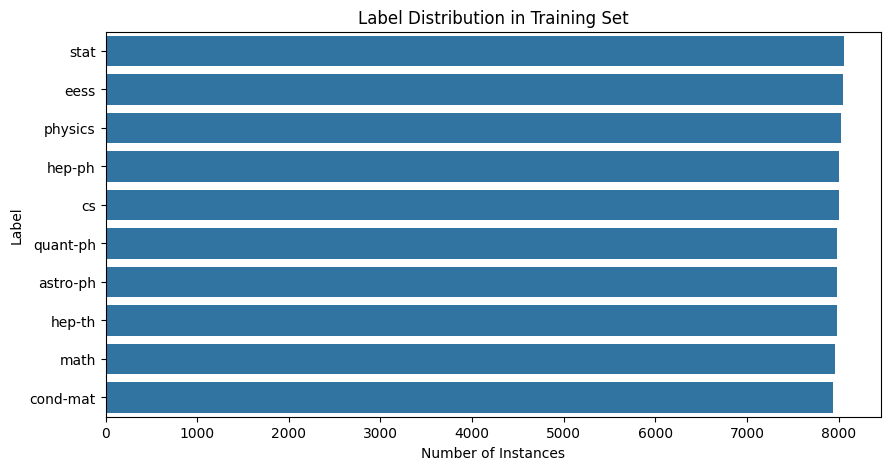

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title('Label Distribution in Training Set')
plt.xlabel('Number of Instances')
plt.ylabel('Label')
plt.show()


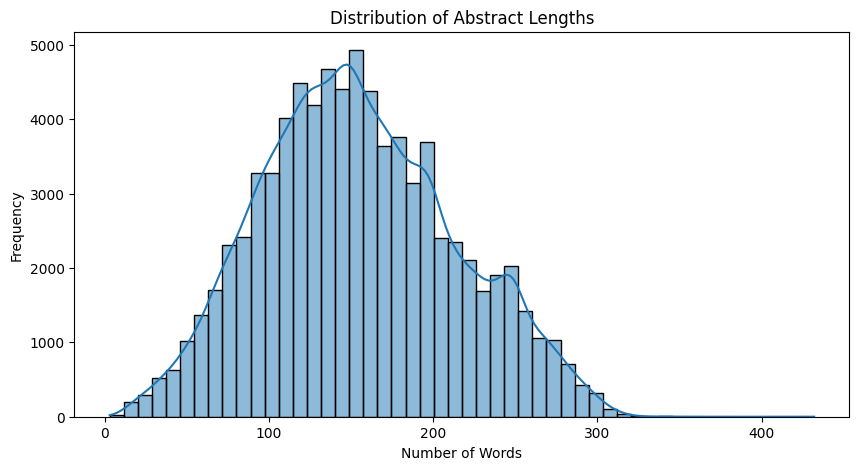

In [5]:
train_df['abstract_length'] = train_df['abstract'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(train_df['abstract_length'], bins=50, kde=True)
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


### starting preprocessing you lame ass nigga

- checking null values

In [187]:
print("Train missing values:\n", train_df.isnull().sum())
print("Test missing values:\n", test_df.isnull().sum())

Train missing values:
 Unnamed: 0    0
abstract      0
label         0
dtype: int64
Test missing values:
 Unnamed: 0    0
abstract      0
label         0
dtype: int64


- removing na

In [188]:
train_df.dropna(subset=['abstract', 'label'], inplace=True)
test_df.dropna(subset=['abstract', 'label'], inplace=True)

- removing extra spaces, new lines, tabs

In [189]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

train_df['clean_abstract'] = train_df['abstract'].apply(clean_text)
test_df['clean_abstract'] = test_df['abstract'].apply(clean_text)


In [190]:
# we dont need it!!!!!!!
train_df.head()
print(train_df.columns)
# Check the type of the first element in the 'clean_abstract' column
print(type(train_df['clean_abstract'].iloc[0]))

Index(['Unnamed: 0', 'abstract', 'label', 'clean_abstract'], dtype='object')
<class 'str'>


 Apply the Tokenization to Your DataFrame

In [191]:
import re

def simple_tokenize(text):
    # use re.findall to grab sequences of word characters (letters/numbers)
    tokens = re.findall(r'\b\w+\b', text) 
    return tokens

train_df['tokens'] = train_df['clean_abstract'].apply(simple_tokenize)
test_df['tokens'] = test_df['clean_abstract'].apply(simple_tokenize)

print(train_df[['clean_abstract', 'tokens']].head())
print(type(train_df['clean_abstract'].iloc[0]))
print(train_df.columns)


                                      clean_abstract  \
0  automatic meeting analysis is an essential fun...   
1  we propose a protocol to encode classical bits...   
2  a number of physically intuitive results for t...   
3  in the last decade rare-earth hexaborides have...   
4  we introduce the weak barycenter of a family o...   

                                              tokens  
0  [automatic, meeting, analysis, is, an, essenti...  
1  [we, propose, a, protocol, to, encode, classic...  
2  [a, number, of, physically, intuitive, results...  
3  [in, the, last, decade, rare, earth, hexaborid...  
4  [we, introduce, the, weak, barycenter, of, a, ...  
<class 'str'>
Index(['Unnamed: 0', 'abstract', 'label', 'clean_abstract', 'tokens'], dtype='object')


- encoding labels as integers because its a multiclass problem

In [192]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

# Save the mapping for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {'astro-ph': 0, 'cond-mat': 1, 'cs': 2, 'eess': 3, 'hep-ph': 4, 'hep-th': 5, 'math': 6, 'physics': 7, 'quant-ph': 8, 'stat': 9}


- Stratified Train/Dev Split

In [193]:
from sklearn.model_selection import train_test_split

# Stratified split on the encoded labels
train_texts, dev_texts, train_labels, dev_labels = train_test_split(
    train_df['clean_abstract'],
    train_df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['label_encoded']
)

# Optional sanity check: label distribution
print("Train label distribution:\n", train_labels.value_counts(normalize=True))
print("Dev label distribution:\n", dev_labels.value_counts(normalize=True))

Train label distribution:
 label_encoded
9    0.100687
3    0.100656
7    0.100281
4    0.100125
2    0.100062
0    0.099844
8    0.099828
5    0.099766
6    0.099469
1    0.099281
Name: proportion, dtype: float64
Dev label distribution:
 label_encoded
9    0.100687
3    0.100625
7    0.100312
4    0.100125
2    0.100062
8    0.099875
0    0.099812
5    0.099750
6    0.099500
1    0.099250
Name: proportion, dtype: float64


In [194]:
y_train = train_labels.values
y_dev = dev_labels.values
label_map = {'astro-ph': 0, 'cond-mat': 1, 'cs': 2, 'eess': 3, 'hep-ph': 4,
             'hep-th': 5, 'math': 6, 'physics': 7, 'quant-ph': 8, 'stat': 9}

# step 1 : text vectorization

- basic count vectorizer

In [195]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

# Fit only on training data
X_train_count = count_vectorizer.fit_transform(train_texts)
X_dev_count = count_vectorizer.transform(dev_texts)

print("CountVectorizer shape (train):", X_train_count.shape)
print("CountVectorizer shape (dev):", X_dev_count.shape)


CountVectorizer shape (train): (64000, 10000)
CountVectorizer shape (dev): (16000, 10000)


- TF-IDF Vectorization

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

# Fit only on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_dev_tfidf = tfidf_vectorizer.transform(dev_texts)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (dev):", X_dev_tfidf.shape)


TF-IDF shape (train): (64000, 10000)
TF-IDF shape (dev): (16000, 10000)


# building MLP

In [197]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report

- converting data to tensors

# run this for BOW tensors

In [198]:
# Convert sparse matrices to dense and then to tensors
X_train_tensor = torch.tensor(X_train_count.toarray(), dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev_count.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64)

# run this for TF-IDF tensors

In [199]:
# X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
# X_dev_tensor = torch.tensor(X_dev_tfidf.toarray(), dtype=torch.float32)

# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# dev_loader = DataLoader(dev_dataset, batch_size=64)


- definfing the model

(fine tune this model with different numbers of layers)

In [200]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(FeedforwardNN, self).__init__()
        layers = []
        current_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(current_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))  # Regularization
            current_dim = h
        layers.append(nn.Linear(current_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [201]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FeedforwardNN(input_dim=10000, hidden_dims=[128], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

Epoch 1/5 - Loss: 1162.9699
Epoch 2/5 - Loss: 581.9994
Epoch 3/5 - Loss: 480.6258
Epoch 4/5 - Loss: 421.0802
Epoch 5/5 - Loss: 373.9755


Accuracy on dev set: 84.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1597
           1       0.83      0.81      0.82      1588
           2       0.74      0.71      0.73      1601
           3       0.79      0.82      0.81      1610
           4       0.93      0.93      0.93      1602
           5       0.91      0.91      0.91      1596
           6       0.83      0.88      0.85      1592
           7       0.73      0.70      0.71      1605
           8       0.87      0.89      0.88      1598
           9       0.82      0.84      0.83      1611

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000


Confusion Matrix:
[[1500    0    4    4   22    8    3   48    1    7]
 [   0 1287   13    3    3   23   22  154   80    3]
 [   0    1 1137  201    1    0   89   26   12  134]
 [   3    0

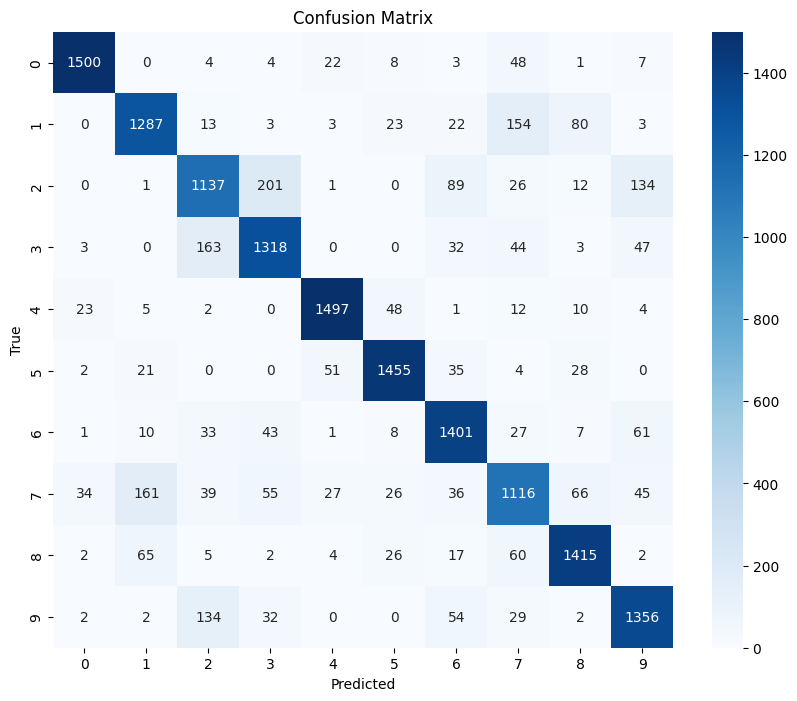

In [202]:
# Evaluate the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dev_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        # Collect predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
        # Calculate accuracy
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on dev set: {accuracy:.2f}%')

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# run this for TF-IDF tensors

In [203]:
X_train_tensor_tf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_dev_tensor_tf = torch.tensor(X_dev_tfidf.toarray(), dtype=torch.float32)

train_dataset_tf = TensorDataset(X_train_tensor_tf, y_train_tensor)
dev_dataset_tf = TensorDataset(X_dev_tensor_tf, y_dev_tensor)

train_loader_tf = DataLoader(train_dataset_tf, batch_size=64, shuffle=True)
dev_loader_tf = DataLoader(dev_dataset_tf, batch_size=64)

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FeedforwardNN(input_dim=10000, hidden_dims=[256], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader_tf:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

Epoch 1/10 - Loss: 1758.7359
Epoch 2/10 - Loss: 842.0802
Epoch 3/10 - Loss: 602.1464
Epoch 4/10 - Loss: 510.6177
Epoch 5/10 - Loss: 459.2322
Epoch 6/10 - Loss: 424.1742
Epoch 7/10 - Loss: 396.4181
Epoch 8/10 - Loss: 372.3333
Epoch 9/10 - Loss: 352.8686
Epoch 10/10 - Loss: 334.6440


Accuracy on dev set: 84.46%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1597
           1       0.83      0.81      0.82      1588
           2       0.74      0.71      0.73      1601
           3       0.80      0.83      0.81      1610
           4       0.94      0.93      0.94      1602
           5       0.91      0.93      0.92      1596
           6       0.86      0.87      0.86      1592
           7       0.72      0.71      0.71      1605
           8       0.88      0.87      0.88      1598
           9       0.81      0.85      0.83      1611

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000


Confusion Matrix:
[[1490    0    5    4   21    9    2   56    1    9]
 [   0 1286   12    4    2   26   18  163   73    4]
 [   0    1 1142  199    0    0   76   30   11  142]
 [   3    0

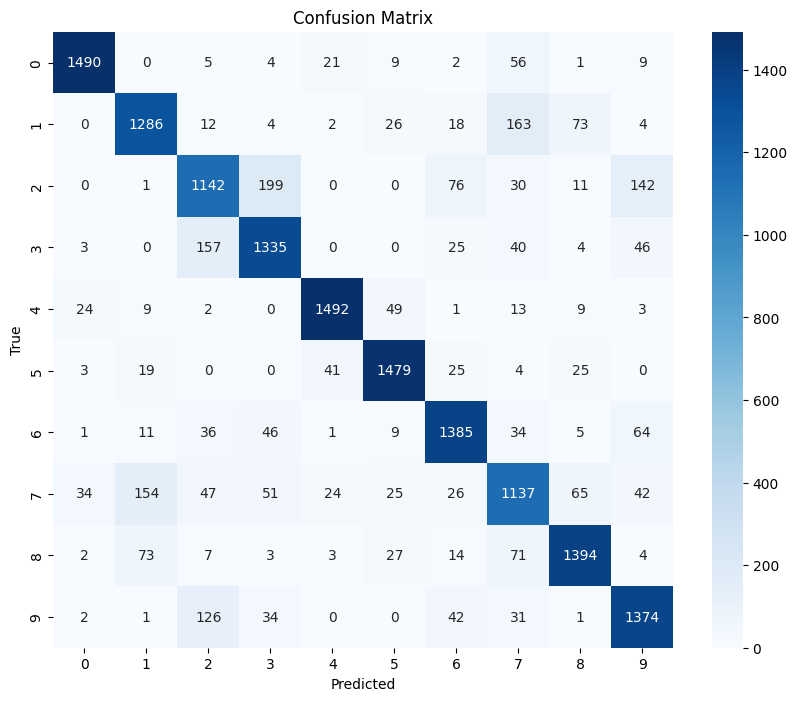

In [205]:
# Evaluate the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dev_loader_tf:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        # Collect predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
        # Calculate accuracy
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on dev set: {accuracy:.2f}%')

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# results with BOW tensors 
- Epoch 1/5 - Loss: 706.6508
- Epoch 2/5 - Loss: 390.9463
- Epoch 3/5 - Loss: 277.9484
- Epoch 4/5 - Loss: 196.3589
- Epoch 5/5 - Loss: 142.3870

# rusults with TF-IDF tensors 
- Epoch 1/5 - Loss: 831.5841
- Epoch 2/5 - Loss: 439.9397
- Epoch 3/5 - Loss: 336.5091
- Epoch 4/5 - Loss: 258.9744
- Epoch 5/5 - Loss: 196.4470

# compraing BOW and TF

In [206]:
import pandas as pd

# Define the metrics for both models
data = {
    "Metric": [
        "Accuracy", "Macro F1", "Weighted F1", 
        "Astro-ph F1", "Cond-mat F1", "CS F1", "EESS F1", "Hep-ph F1", 
        "Hep-th F1", "Math F1", "Physics F1", "Quant-ph F1", "Stat F1"
    ],
    "CountVectorizer": [
        0.83, 0.83, 0.83,
        0.93, 0.80, 0.70, 0.79, 0.93,
        0.91, 0.85, 0.69, 0.86, 0.80
    ],
    "TF-IDF": [
        0.82, 0.82, 0.82,
        0.94, 0.79, 0.70, 0.79, 0.93,
        0.91, 0.84, 0.68, 0.86, 0.81
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Print the table
print(df.to_string(index=False))


     Metric  CountVectorizer  TF-IDF
   Accuracy             0.83    0.82
   Macro F1             0.83    0.82
Weighted F1             0.83    0.82
Astro-ph F1             0.93    0.94
Cond-mat F1             0.80    0.79
      CS F1             0.70    0.70
    EESS F1             0.79    0.79
  Hep-ph F1             0.93    0.93
  Hep-th F1             0.91    0.91
    Math F1             0.85    0.84
 Physics F1             0.69    0.68
Quant-ph F1             0.86    0.86
    Stat F1             0.80    0.81


# next steps (for said)

- You're in a great spot to move to Step 2: Pretrained Word Embeddings. Here's what you could try next:

- Replace BoW with averaged GloVe or word2vec embeddings for each abstract.

- Use mean/sum/max pooling over word embeddings to create document vectors.

- Feed those vectors into the same MLP structure for a fair comparison.

### Loading Pretrained Word Embeddings

You can use pretrained embeddings such as GloVe or word2vec. In this example, we’ll use GloVe with a dimension of 300. First, download the GloVe file (e.g., glove.6B.300d.txt) if you haven’t already.

In [207]:
import numpy as np

embedding_index = {}
embedding_dim = 300  # Change this depending on which embedding file you use

# Open the GloVe file (ensure the file is in your working directory)
with open('glove.6B.300d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients
        
print("Loaded {} word vectors.".format(len(embedding_index)))

Loaded 400000 word vectors.


 ### Converting Abstracts into Document Vectors

Instead of using BoW, you now create a fixed-sized vector for each abstract by aggregating its word embeddings.

a. Define a Function to Compute the Document Vector

Here is a function that aggregates word embeddings from the tokens with your choice of pooling method. In this code, we demonstrate mean pooling. (You can change 'mean' to 'sum' or 'max' in the call if you prefer.)

In [208]:
def get_document_vector(tokens, embedding_index, embedding_dim=300, pooling='mean'):
    # Collect embeddings for words that are present in the pretrained dictionary
    valid_vectors = [embedding_index[word] for word in tokens if word in embedding_index]
    if not valid_vectors:
        # If none of the words are in the embedding dictionary, return a zero vector
        return np.zeros(embedding_dim)
    valid_vectors = np.array(valid_vectors)
    
    if pooling == 'mean':
        return np.mean(valid_vectors, axis=0)
    elif pooling == 'sum':
        return np.sum(valid_vectors, axis=0)
    elif pooling == 'max':
        return np.max(valid_vectors, axis=0)
    else:
        raise ValueError("Unsupported pooling type. Choose 'mean', 'sum', or 'max'.")

b. Create Document Vectors for Training and Test Sets

Apply the function to each set of tokens:

In [285]:
# For training data

X_train = np.vstack(train_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='sum')))
y_train = train_df['label'].values

# For test data
X_test = np.vstack(test_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='sum')))
y_test = test_df['label'].values

### 1. Convert String Labels to Integers

You can use LabelEncoder from scikit-learn to transform your string labels into integers.
a. Import and Apply LabelEncoder

In [286]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit the encoder on your training labels and transform them into integers
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)  # Transform test labels using the same encoder

# Optionally, check the mapping
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Label mapping: {'astro-ph': 0, 'cond-mat': 1, 'cs': 2, 'eess': 3, 'hep-ph': 4, 'hep-th': 5, 'math': 6, 'physics': 7, 'quant-ph': 8, 'stat': 9}


### 4. Building and Training the MLP Classifier

Now that you have your fixed-size document vectors, you can train an MLP. Here’s an example using TensorFlow/Keras.

a. Prepare the Data

If you’re doing multi-class classification, convert your labels into categorical format.

In [287]:
import tensorflow as tf
to_categorical = tf.keras.utils.to_categorical

# Determine the number of classes using the unique classes from the encoder
num_classes = len(le.classes_)

# Convert integer labels to one-hot encoded vectors
y_train_cat = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)


b. Define the Model Architecture

Set up a simple feed-forward neural network.

# model for mean pooling

In [288]:
# import tensorflow as tf

# # Equivalent references
# Sequential = tf.keras.models.Sequential
# Dense = tf.keras.layers.Dense
# Dropout = tf.keras.layers.Dropout
# BatchNormalization = tf.keras.layers.BatchNormalization
# model = Sequential()

# # First hidden layer with 128 neurons
# model.add(Dense(265, activation='relu', input_shape=(embedding_dim,)))
# # model.add(BatchNormalization())
# model.add(Dropout(0.3))
# # Second hidden layer with 64 neurons
# model.add(Dense(128, activation='relu'))
# # model.add(BatchNormalization())

# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# # Output layer with softmax activation
# model.add(Dense(num_classes, activation='softmax'))
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.summary()


# model for max pooling 

In [289]:
# import tensorflow as tf
# from tensorflow.keras.layers import LeakyReLU
# # Equivalent references
# Sequential = tf.keras.models.Sequential
# Dense = tf.keras.layers.Dense
# Dropout = tf.keras.layers.Dropout
# BatchNormalization = tf.keras.layers.BatchNormalization
# model = Sequential()

# model.add(Dense(1024))
# model.add(LeakyReLU(alpha=0.1))
# model.add(BatchNormalization())
# # this layer was only used with max
# model.add(Dense(512, activation='relu', input_shape=(embedding_dim,)))
# # model.add(BatchNormalization())
# model.add(Dropout(0.5))
# # First hidden layer with 128 neurons
# model.add(Dense(265, activation='relu', input_shape=(embedding_dim,)))
# # model.add(BatchNormalization())
# model.add(Dropout(0.4))
# # Second hidden layer with 64 neurons
# model.add(Dense(128, activation='relu'))
# # model.add(BatchNormalization())

# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# # Output layer with softmax activation
# model.add(Dense(num_classes, activation='softmax'))

# # for max embeddings use this line below
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.summary()


# model for sum pooling

In [331]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Larger input due to sum pooling; batch norm helps normalize it
model.add(BatchNormalization(input_shape=(embedding_dim,)))

# First dense layer
model.add(Dense(192, activation='relu'))  # Slightly reduced size
model.add(Dropout(0.15))

# Second dense layer
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.15))

# Third dense layer
model.add(Dense(48, activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0002)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()


C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_26          │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 192)            │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,666 (322.91 KB)

 Trainable params: 82,066 (320.57 KB)

 Non-trainable params: 600 (2.34 KB)

c. Train the Model

Train on your training data and validate on the test set:

In [333]:
# mean embeddings
# history = model.fit(X_train, y_train_cat, epochs=15, batch_size=16, validation_data=(X_test, y_test_cat))

#max embeggings
# history = model.fit(X_train, y_train_cat, epochs=15, batch_size=16, validation_data=(X_test, y_test_cat))

#sum embeddings
# history = model.fit(X_train, y_train_cat, epochs=18, batch_size=32, validation_data=(X_test, y_test_cat))
history = model.fit(
    X_train, y_train_cat,  # Sum-pooled GloVe input + one-hot labels
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_sum_pool_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
)


Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7779 - loss: 0.6304 - val_accuracy: 0.7931 - val_loss: 0.5848
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7817 - loss: 0.6138 - val_accuracy: 0.7914 - val_loss: 0.5876
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7836 - loss: 0.6127 - val_accuracy: 0.7951 - val_loss: 0.5823
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7891 - loss: 0.6006 - val_accuracy: 0.7966 - val_loss: 0.5803
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7877 - loss: 0.5972 - val_accuracy: 0.7948 - val_loss: 0.5795
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7912 - loss: 0.5882 - val_accuracy: 0.7959 - val_loss: 0.5751
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7937 - loss: 0.5852 - val_accuracy: 0.7952 - val_loss: 0.5735
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7951 - loss: 0

. Evaluating the Classifier

After training, evaluate the model’s performance on unseen data.

a. Calculate Accuracy

In [334]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print("Test Accuracy:", accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7927 - loss: 0.5766
Test Accuracy: 0.7976999878883362


b. Generate a Detailed Classification Report

For additional metrics like precision, recall, and F1-score, use scikit-learn:

In [335]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report

# Now, compare the encoded ground-truth and predicted labels
print(classification_report(y_test_encoded, y_pred))


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2013
           1       0.80      0.74      0.77      2058
           2       0.70      0.68      0.69      1995
           3       0.70      0.80      0.75      1948
           4       0.88      0.91      0.89      1990
           5       0.87      0.84      0.85      2019
           6       0.83      0.83      0.83      2042
           7       0.66      0.63      0.65      1977
           8       0.82      0.85      0.83      2013
           9       0.78      0.81      0.79      1945

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



In [336]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


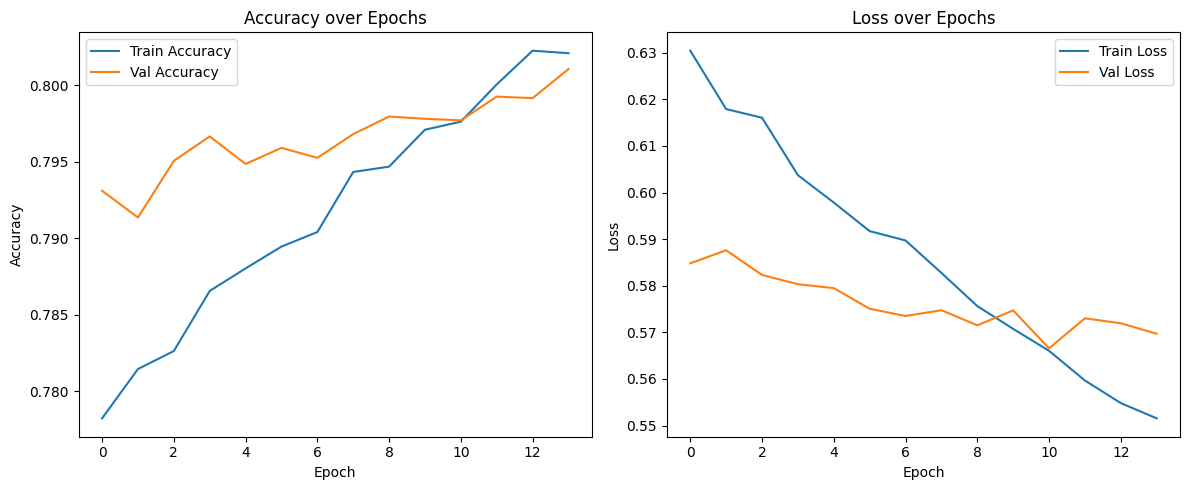

In [337]:
plot_training_history(history)
